# Predict Gun Control Votes

This was a toy project to see if I could predict whether someone would vote for gun control legislation. There were a number of things I wanted to try like 
 - party affiliation
 - whether someone is in the majority party
 - how much they won their previous election by

I identified a few interesting factors, like that party affiliation is highly correlated with NRA ratings. But in the end the NRA rating was the only feature necessary to make an accurate prediction. 

In [1]:
import xlrd
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

In [2]:
# https://github.com/unitedstates/congress-legislators
# read legislators from a csv file
legislators     = pd.read_csv('legislators-current.csv')
senators        = legislators[legislators.type == 'sen']
representatives = legislators[legislators.type == 'rep']

In [3]:
# get information about representative's terms
terms = pd.read_json('legislators-current.json')

In [4]:
# https://en.wikipedia.org/wiki/Party_leaders_of_the_United_States_Senate#History
# dictionary of changes in majority party
majority_party = {}
majority_party['January-03-1995'] = 'Republican'
majority_party['January-03-2001'] = 'Democrat'
majority_party['January-20-2001'] = 'Republican'
majority_party['June-06-2001']    = 'Democrat'
majority_party['January-03-2003'] = 'Republican'
majority_party['January-03-2007'] = 'Democrat'
majority_party['January-03-2015'] = 'Republican'

In [5]:
# save the full name of the senator
full_name = []
for first, last in zip(senators.first_name, senators.last_name):
    full_name.append(', '.join([last,first]))
senators['full_name'] = full_name

# build a list of years in the excel sheet
years = list(range(2004,2017,2))

# grab the election results for all current senators
election_results = []
key = ['LAST NAME, FIRST', 'LAST NAME, FIRST']
key += ['CANDIDATE NAME' for _ in range(7)]
for i, year in enumerate(years):
    election_df = pd.read_excel('senate_election_results.xlsx', sheet_name=str(year))
    election_df['year'] = year
    
    # check the vote percentage for each senator in this election
    for senator, state in zip(full_name, senators.state):
        if senator in list(election_df[key[i]]):
            index = election_df.index[election_df[key[i]] == senator][0]
            if election_df.iloc[index].DISTRICT == 'S' and election_df.iloc[index]['STATE ABBREVIATION'] == state:
                election_results.append({
                    'year'         : year,
                    'full_name'    : senator,
                    'vote_percent' : election_df.iloc[index]['GENERAL %']
                })
#   print()
election_results = pd.DataFrame(election_results)

In [6]:
# grab the nra ratings 
nra = pd.read_pickle('Gun_Legislation/nra_all_years.pickle')
nra_senate = nra[nra.Office == 'U.S. Senate']

In [7]:
nra_years = nra_senate.Year.unique().tolist()
nra_years

[2018, 2017, 2016, 2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000, 1993]

In [8]:
# loop over current senators
all_ratings, avg_ratings = [], []
for first_name, last_name, cspan_id in zip(senators.first_name, senators.last_name, senators.cspan_id):
    
    # find all their ratings
    total, count = 0, 0
    senator_ratings = {'cspan_id': cspan_id}
    for index, row in nra_senate.iterrows():
        if first_name in row['Name'] and last_name in row['Name']:
            senator_ratings[str(row['Year'])+'_nra_rating'] = row['Rating']
            if row['Year'] < 2013:
                total += int(row['Rating'])
                count += 1
    if (count > 1):
        avg_ratings.append({'cspan_id'       : cspan_id,
                            'avg_nra_rating' : total/count})
    else:
        avg_ratings.append({'cspan_id'       : cspan_id,
                            'avg_nra_rating' : -1})
    
    all_ratings.append(senator_ratings)

senator_ratings = pd.DataFrame(all_ratings)
avg_ratings     = pd.DataFrame(avg_ratings)

In [9]:
# save their nra ratings
senators = pd.merge(senators, senator_ratings, on='cspan_id', how='left')
senators = pd.merge(senators, avg_ratings, on='cspan_id', how='left')

In [10]:
senators[senators.avg_nra_rating != -1][['party', 'avg_nra_rating']].groupby('party').mean()

,avg_nra_rating
party,
Democrat,22.492222
Republican,91.675000


In [11]:
# impute values for avg rating based on party (Independents usually caucus with Dems)  
senators.loc[(((senators.party == 'Democrat') | (senators.party == 'Independent')) \
              & (senators.avg_nra_rating == -1)), 'avg_nra_rating'] = 22.492222
senators.loc[((senators.party == 'Republican') \
              & (senators.avg_nra_rating == -1)), 'avg_nra_rating'] = 91.675000
senators[senators.avg_nra_rating != -1][['party', 'avg_nra_rating']].groupby('party').mean()

,avg_nra_rating
party,
Democrat,22.492222
Independent,22.492222
Republican,91.675000


In [12]:
# grab names of each gun bill
senate_votes_excel = 'senate_voting_data.xlsx'
xls = xlrd.open_workbook(senate_votes_excel, on_demand=True)
gun_bills = xls.sheet_names()

# find the votes for each current senator
senator_votes = []
for bill in gun_bills:
    votes = pd.read_excel(senate_votes_excel, sheet_name=bill)
    for first_name, last_name, cspan_id in zip(senators.first_name, senators.last_name, senators.cspan_id):
        for i, name in enumerate(votes.Name):
            if first_name in name and last_name in name:
                senator_votes.append({
                    'bill'       : bill, 
                    'cspan_id'   : cspan_id,
                    'vote'       : votes.Vote[i]
                })
senator_votes = pd.DataFrame(senator_votes)

In [13]:
# merge the senators and the votes together
df = pd.merge(senators, senator_votes, on='cspan_id', how='left')

In [14]:
# define whether they're in the majority party at the time of the vote
vote_dates = {'Conceal Reciprocity, 2013' : 'April 17, 2013', 
              'Manchin-Toomey, 2015'      : 'December 03, 2015',
              'Murphy Amendment, 2016'    : 'June 20, 2016', 
              'Feinstein Amendment, 2016' : 'June 20, 2016'    }
df['vote_dates'] = df.bill.map(vote_dates)
majority = {'Conceal Reciprocity, 2013' : 'Democrat', 
            'Manchin-Toomey, 2015'      : 'Democrat',
            'Murphy Amendment, 2016'    : 'Republican', 
            'Feinstein Amendment, 2016' : 'Republican'  }
df['majority_party'] = df.bill.map(majority)
df['in_majority'] = df.party == df.majority_party
df.in_majority = df.in_majority.map({True : 1, False : 0})

In [15]:
# encode whether the bill expands gun rights or limits
gun_control = {'Conceal Reciprocity, 2013' : 0, 
               'Manchin-Toomey, 2015'      : 1,
               'Murphy Amendment, 2016'    : 1, 
               'Feinstein Amendment, 2016' : 0 }
df['gun_control'] = df.bill.map(gun_control)

In [16]:
# encode yes and no votes
df.vote = df.vote.map({ 'Nay'        : 0, 
                        'Yea'        : 1, 
                        'Not Voting' : 'abstain' })
# remove abstains
df = df[df.vote != 'abstain']

In [17]:
# encode their gender
df.gender = df.gender.map({ 'M' : 1, 
                            'F' : 0 })

In [18]:
def append_dummies(df, columns):
    ''' Append dummy versions of columns to a dataframe '''
    for col in columns:
        dummy_col = pd.get_dummies(df[col])
        df[dummy_col.columns.tolist()] = dummy_col
    return df

In [19]:
dummy_columns = ['state', 'party']
df = append_dummies(df, dummy_columns)

In [20]:
for bill in list(df.bill.unique())[:-1]:
    print(bill)
    avg_vote = df[['party', 'vote', 'bill']].dropna(how='any')
    avg_vote = avg_vote[avg_vote.bill == bill]
    avg_vote.vote = avg_vote.vote.astype('int')
    print(avg_vote.groupby('party').mean())
    print()

Conceal Reciprocity, 2013
                 vote
party                
Democrat     0.189189
Independent  0.000000
Republican   1.000000

Manchin-Toomey, 2015
                 vote
party                
Democrat     0.967742
Independent  1.000000
Republican   0.047619

Murphy Amendment, 2016
                 vote
party                
Democrat     0.923077
Independent  1.000000
Republican   0.000000

Feinstein Amendment, 2016
                 vote
party                
Democrat     0.051282
Independent  0.000000
Republican   0.958333



In [21]:
# create a new target variable and see the breakdown between parties and gender
df['for_control'] = df.gun_control == df.vote
avg_vote = df[['party', 'gender', 'for_control', 'avg_nra_rating']].dropna(how='any')
print(avg_vote.groupby('party').mean())
print(avg_vote.groupby('gender').mean())

               gender  for_control  avg_nra_rating
party                                             
Democrat     0.653595     0.869281       22.784226
Independent  1.000000     1.000000       22.492222
Republican   0.898876     0.022472       91.667556
        for_control  avg_nra_rating
gender                             
0          0.661972       34.751604
1          0.363296       65.516454


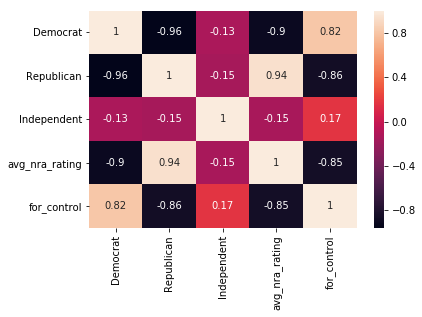

In [22]:
sns.heatmap(df[['Democrat', 'Republican', 'Independent', 'avg_nra_rating', 'for_control']].corr(), annot=True);

# Regression

In [23]:
# features = list(df.party.unique())
features = ['avg_nra_rating']
target   = 'for_control'

In [24]:
def grid_search(base_clf, parameters, scores, X_train, X_test, y_train, y_test):

    # loop over the different scores and see what parameters are best for the different metrics
    for score in scores:
        print("# Tuning hyper-parameters for %s\n" % score)

        clf = GridSearchCV(base_clf, parameters, cv=KFold(10), scoring=score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:\n")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds  = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        
        print("Classification report:\n")
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        
    return clf.best_params_

In [25]:
# separate the last bill vote for testing
test_bill = list(df.bill.unique())[-2]
print("Testing Bill: ", test_bill)

no_null = df[features+[target, 'bill']].dropna(how='any')
train = no_null[no_null.bill != test_bill]
test  = no_null[no_null.bill == test_bill]
X_train, y_train = train[features], train[target].tolist()
X_test, y_test   = test[features], test[target].tolist()

Testing Bill:  Feinstein Amendment, 2016


In [26]:
# define the parameters to test
parameters =  { 'penalty' : ['l1' ,'l2'], 
                'C'       : [0.1, 1, 10, 100, 1000] }

# define the metrics we'll use to score the different parameters on
scores = ['accuracy']

# tune the hyper parameters
params = grid_search(LogisticRegression(), parameters, scores, 
                     X_train, X_test, y_train, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'penalty': 'l1'}

Grid scores on development set:

0.925 (+/-0.139) for {'C': 0.1, 'penalty': 'l1'}
0.925 (+/-0.139) for {'C': 0.1, 'penalty': 'l2'}
0.925 (+/-0.139) for {'C': 1, 'penalty': 'l1'}
0.925 (+/-0.139) for {'C': 1, 'penalty': 'l2'}
0.937 (+/-0.108) for {'C': 10, 'penalty': 'l1'}
0.937 (+/-0.108) for {'C': 10, 'penalty': 'l2'}
0.937 (+/-0.108) for {'C': 100, 'penalty': 'l1'}
0.937 (+/-0.108) for {'C': 100, 'penalty': 'l2'}
0.937 (+/-0.108) for {'C': 1000, 'penalty': 'l1'}
0.937 (+/-0.108) for {'C': 1000, 'penalty': 'l2'}

Classification report:

             precision    recall  f1-score   support

      False       0.94      0.98      0.96        48
       True       0.97      0.93      0.95        41

avg / total       0.96      0.96      0.95        89




In [27]:
clf = LogisticRegression()#**params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.92      0.98      0.95        48
       True       0.97      0.90      0.94        41

avg / total       0.95      0.94      0.94        89



In [28]:
def plot_distribution(series):
    '''Plot distribution compared to normal and print out some summary statistics'''
    from scipy import stats
    
    mu, sigma, skew = series.mean(), series.std(), series.skew()
    print( '\n mu = {:.2f}, sigma = {:.2f}, skew = {:.2f}'.format(mu, sigma, skew))
    
    fig = plt.figure()
    fig.set_size_inches(8, 4)

    sns.distplot(series)#, fit=stats.norm)
    
    plt.tight_layout()


 mu = 0.41, sigma = 0.41, skew = 0.28


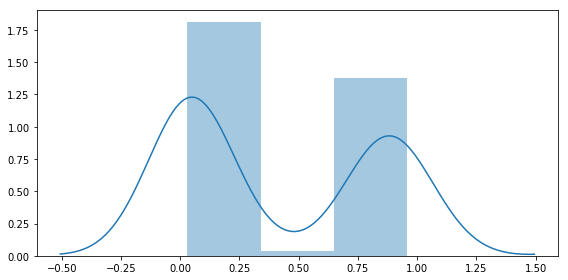

In [29]:
probabilities = clf.predict_proba(X_test)[:,1]
plot_distribution(pd.Series(probabilities))

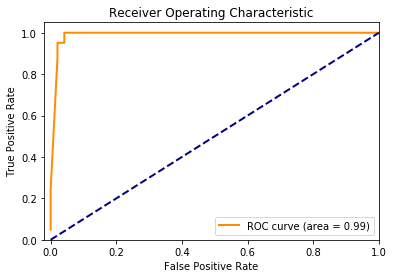

In [30]:
def plot_roc(fpr, tpr):
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([-.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# compute ROC curve and find the appropriate threshold to minimize false negatives
fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plot_roc(fpr, tpr)

In [31]:
# # save the feature importance and sort
# feature_importance = {'%s' % features[i]: coef for i, coef in enumerate(clf.coef_[0])}
# ordered_features = sorted(feature_importance, key=lambda dict_key: abs(feature_importance[dict_key]))
# coefficients = [feature_importance[f] for f in ordered_features]

# # make a bar chart of all features
# ax = sns.barplot(x=ordered_features, y=coefficients)
# plt.title("Log Odds")
# for item in ax.get_xticklabels():
#     item.set_rotation(45)